# Predicción de la demanda de taxis en aeropuertos

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, se requiere predecir la cantidad de pedidos de taxis para la próxima hora. Se construirán varios modelos para realizar dicha predicción, considerando que la métrica RECM en el conjunto de prueba no debe ser superior a 48.

**Tabla de contenidos**<a id='toc0_'></a>    
- [Importación de librerías y carga de datos](#toc1_)    
- [Preprocesamiento de los datos](#toc2_)    
- [Análisis](#toc3_)    
  - [Tendencias y estacionalidad](#toc3_1_)    
  - [Análisis de estacionaridad](#toc3_2_)    
  - [Diferenciación](#toc3_3_)    
- [Entrenamiento de modelos](#toc4_)    
  - [Creación de características](#toc4_1_)    
  - [Entrenamiento de modelos](#toc4_2_)    
    - [Creación de función de RMSE, scorer, cross validator y clase](#toc4_2_1_)    
    - [Decision Tree Regressor](#toc4_2_2_)    
    - [Linear Regression](#toc4_2_3_)    
    - [Random Forest Regressor](#toc4_2_4_)    
    - [XGB Regressor](#toc4_2_5_)    
    - [CatBoost Regressor](#toc4_2_6_)    
    - [LGBM Regressor](#toc4_2_7_)    
  - [Puntajes](#toc4_3_)    
- [Conclusiones](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Importación de librerías y carga de datos](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
import math 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
try:
    data = pd.read_csv('./datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Observamos un dataset con 26496 registros y 2 columnas, la primera con la fecha y hora de la solicitud y la segunda con la cantidad de pedidos de taxis. La columna con la fecha y hora de la solicitud se convierte en el índice del dataframe y se convierte en formato datetime. Los registros muestran un intervalo de 10 minutos entre cada uno.

## <a id='toc2_'></a>[Preprocesamiento de los datos](#toc0_)

In [3]:
# Se cambia el intervalo de tiempo a 1 hora y se obtiene el total de pedidos por hora
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


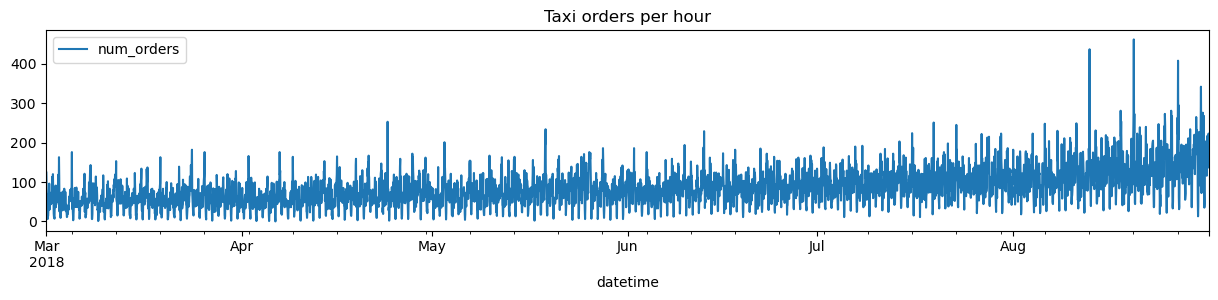

In [4]:
data.plot(figsize=(15, 2.6))
plt.title('Taxi orders per hour')
plt.show()

De momento, el gráfico de la serie temporal se observa saturado y existe dificultad para identificar una tendencia y posible estacionalidad.

## <a id='toc3_'></a>[Análisis](#toc0_)

### <a id='toc3_1_'></a>[Tendencias y estacionalidad](#toc0_)

In [5]:
# Función para descomponer la serie temporal según el período seleccionado y graficarla
def decompose(data, select_period=False, start=None, end=None):
    if select_period:
        if start and end:
            data = data.loc[start:end]
        else:
            data = data.loc[start]
    else:
        data = data
        
    decomposed = seasonal_decompose(data)

    plt.figure(figsize=(15,8))
    plt.subplot(311)

    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

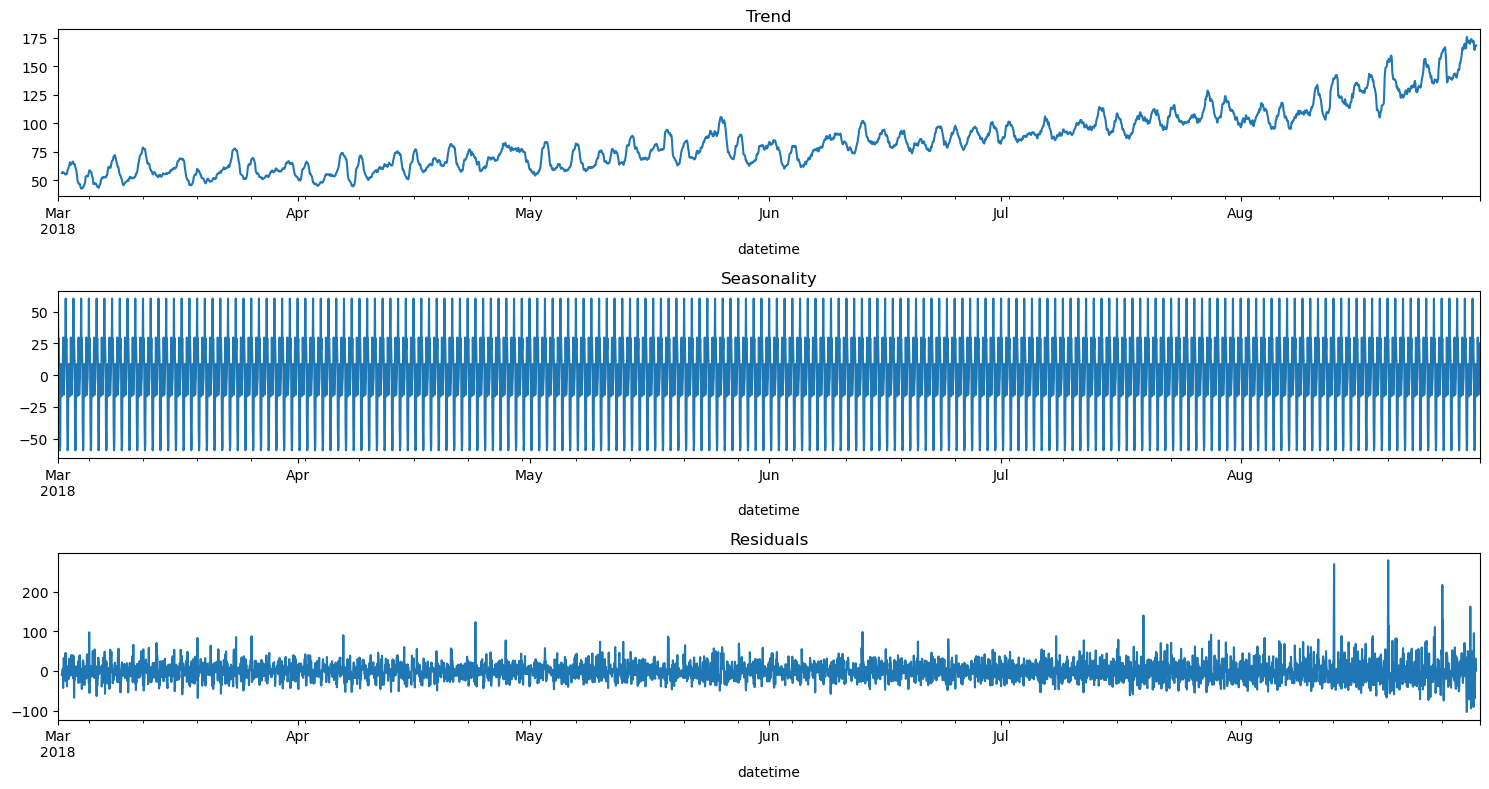

In [6]:
# Descomposición de toda la serie temporal
decompose(data)

- Es posible identificar una tendencia creciente en el número de pedidos a lo largo del período, la cual llega a sus valores más altos durante los meses de verano.
- En cuanto a la estacionalidad, aunque el gráfico se encuentra saturado, se observa una oscilación constante en el número de pedidos que varía entre aproximadamente -60 a 60. 

A continuación se graficará dos períodos de un mes para tener una mejor visualización de la estacionalidad.

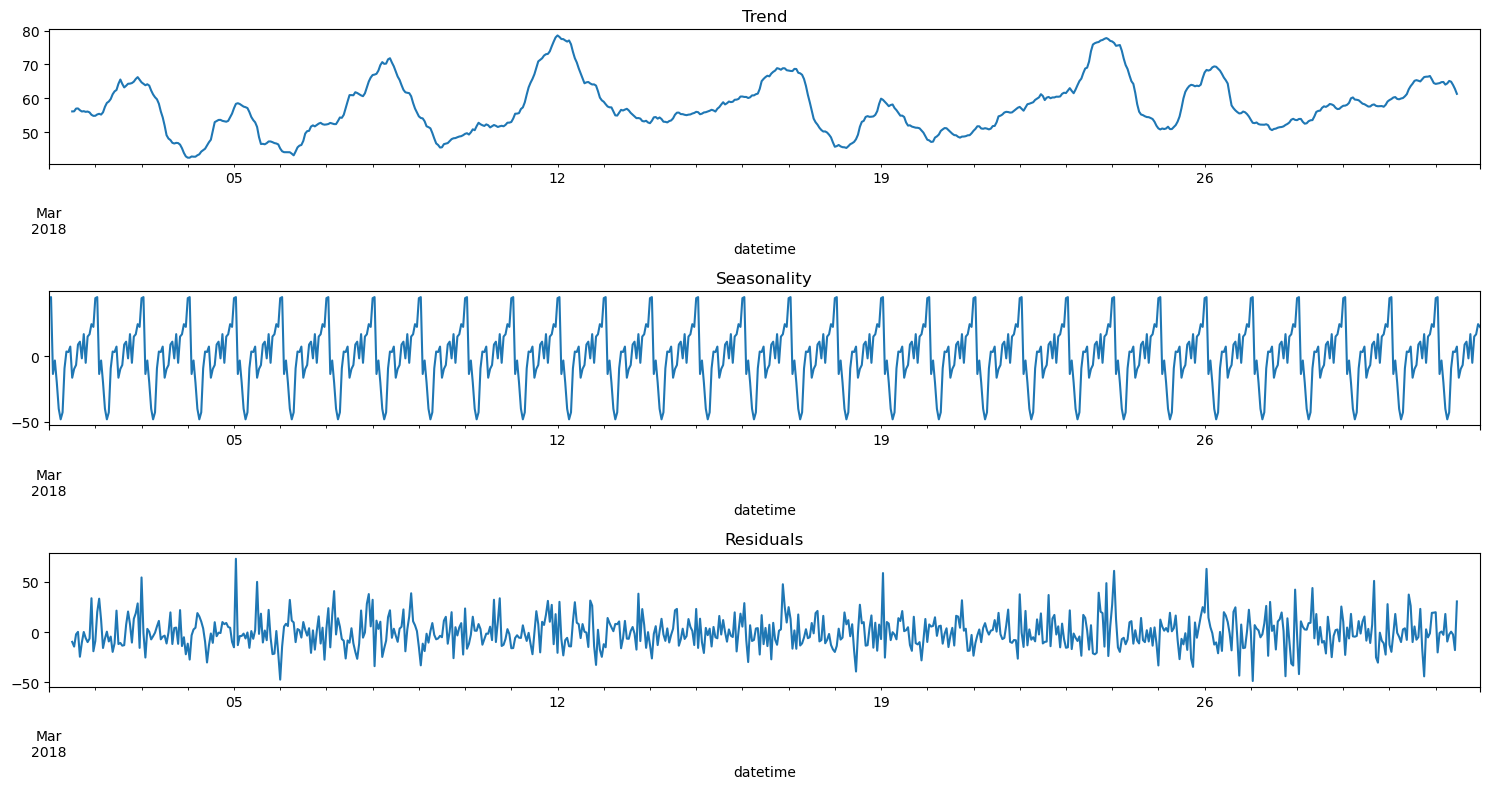

In [7]:
# descomposición de la serie temporal para el mes de marzo de 2018
decompose(data, select_period=True, start='2018-03')

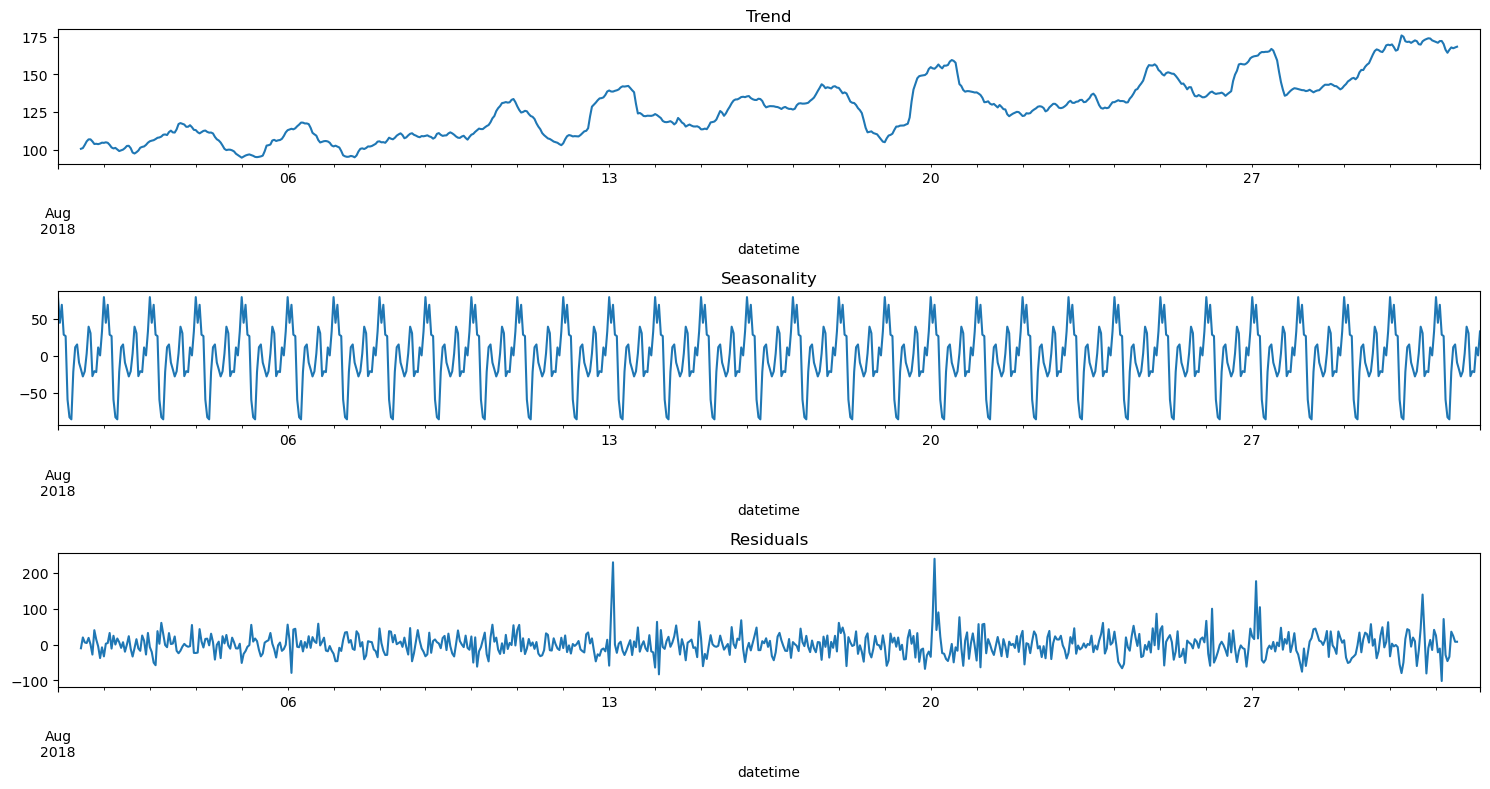

In [8]:
# descomposición de la serie temporal para el mes de agosto de 2018
decompose(data, select_period=True, start='2018-08')

En el mes de marzo no se observa una tendencia clara a lo largo del mes a diferencia de la tendencia de toda la serie temporal. En cambio, en la estacionalidad se puede observar que los pedidos de taxis presentan un patrón diario en el cual los pedidos empiezan a aumentar haciendo varios máximos a partir de las 6:00 am y llegan a su punto más alto a media noche, para luego disminuir nuevamente hasta las 6:00 am del día siguiente. Se observa el mismo patrón en el mes de agosto, donde también se puede distinguir una tendencia creciente a lo largo del mes.

### <a id='toc3_2_'></a>[Análisis de estacionaridad](#toc0_)

In [9]:
# Función para graficar datos con su media móvil y desviación estándar móvil
def stationarity_check(data, window=24):
    rolmean = data.rolling(window=window).mean()
    rolstd = data.rolling(window=window).std()
    
    plt.figure(figsize=(15, 5))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

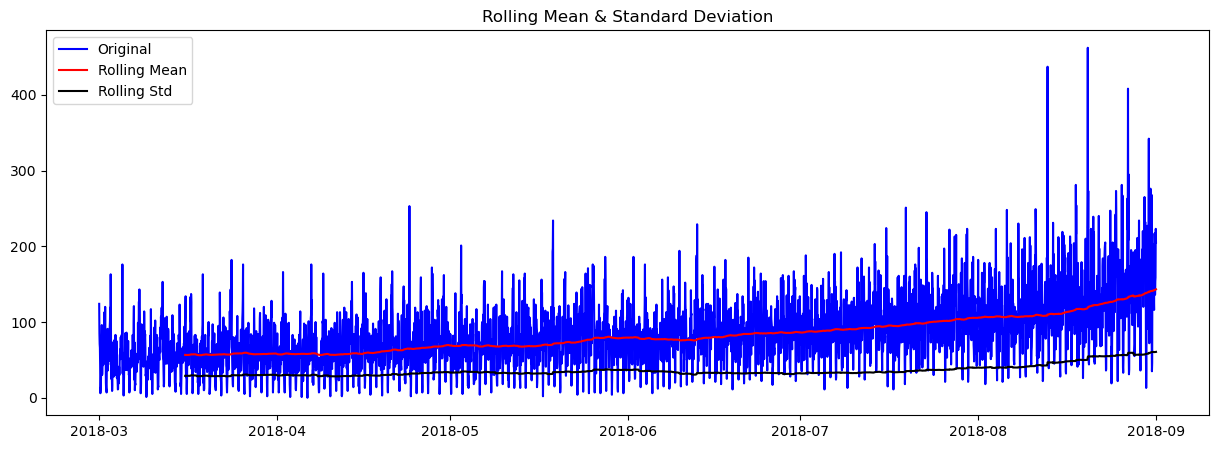

In [10]:
stationarity_check(data, window=360)

Se observa en la gráfica que la media no permanece constante a lo largo del tiempo al presentar una tendencia creciente. De manera similar, la desviación estandar, presenta un ligero incremento hacia el final del período ya que los datos se vuelven más dispersos. Por lo tanto, se puede concluir que la serie temporal no es estacionaria.

### <a id='toc3_3_'></a>[Diferenciación](#toc0_)

Se aplica la ténica de la diferenciación para remover la tendencia de la serie. Se realizará esta diferencia con un desfase de 24 horas a los ciclos diarios que se observaron en la serie.

In [11]:
data_diff = data - data.shift(24)

data_diff.dropna(inplace=True)

data_diff.head()

,num_orders
datetime,
2018-03-02 00:00:00,-34.0
2018-03-02 01:00:00,35.0
2018-03-02 02:00:00,4.0
2018-03-02 03:00:00,-2.0
2018-03-02 04:00:00,-23.0


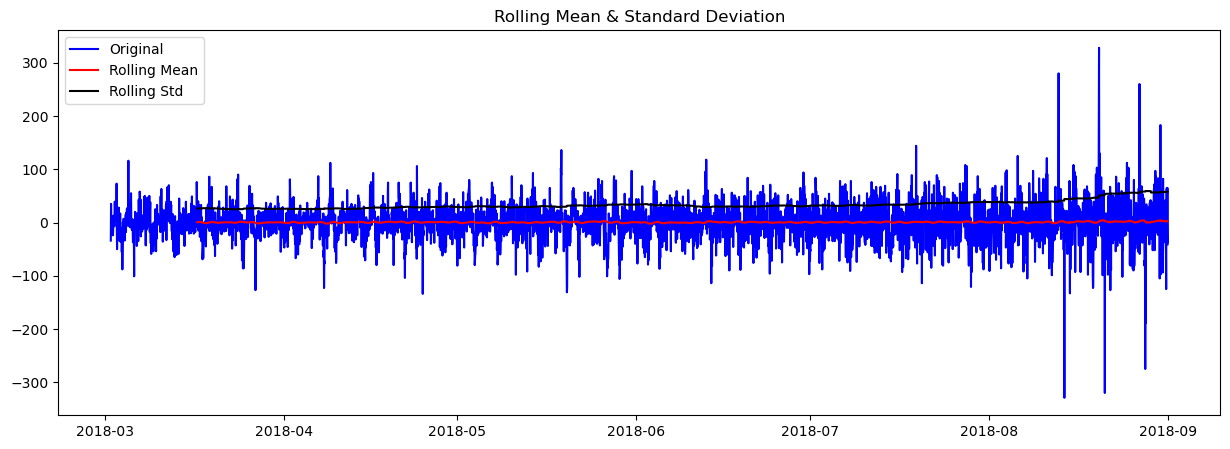

In [12]:
stationarity_check(data_diff, window=360)

La tendencia en este caso se ha eliminado y la media se ha vuelto constante a lo largo del tiempo. La desviación estándar, sin embargo, incrementa ligeramente hacia el final del período, por lo que la serie no termina de ser completamente estacionaria.

## <a id='toc4_'></a>[Entrenamiento de modelos](#toc0_)

Antes de entrenar los modelos, se crean algunas características para la serie.

### <a id='toc4_1_'></a>[Creación de características](#toc0_)

In [13]:
# Función para añadir características a la serie
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.iloc[:,0].shift(lag)

    data['rolling_mean'] = data.iloc[:,0].shift().rolling(rolling_mean_size).mean()
    #data['rolling_std'] = data.iloc[:,0].shift().rolling(rolling_std_size).std()

In [14]:
# Llamada a la función con un desfase máximo de 48 horas para considerar los cambios a lo largo de los días y
# una ventana de 360 horas (correspondiente a aprox. 15 días) para la media móvil 
make_features(data, 48, 360)
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,142.333333
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,142.425000
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,56.0,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,142.605556


Se obtiene un nuevo dataframe con nuevas columnas añadidas, las cuales suman 54 en total. Todas las columnas de lag y rolling mean presentan valores NaN, estos serán removidos a continuación.  

In [15]:
# Se eliminan valores NaN
data = data.dropna()
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-16 00:00:00,110,2018,3,16,4,101.0,85.0,57.0,94.0,49.0,...,35.0,8.0,19.0,15.0,21.0,57.0,39.0,72.0,84.0,56.569444
2018-03-16 01:00:00,134,2018,3,16,4,110.0,101.0,85.0,57.0,94.0,...,60.0,35.0,8.0,19.0,15.0,21.0,57.0,39.0,72.0,56.530556
2018-03-16 02:00:00,39,2018,3,16,4,134.0,110.0,101.0,85.0,57.0,...,46.0,60.0,35.0,8.0,19.0,15.0,21.0,57.0,39.0,56.666667
2018-03-16 03:00:00,27,2018,3,16,4,39.0,134.0,110.0,101.0,85.0,...,58.0,46.0,60.0,35.0,8.0,19.0,15.0,21.0,57.0,56.577778
2018-03-16 04:00:00,47,2018,3,16,4,27.0,39.0,134.0,110.0,101.0,...,41.0,58.0,46.0,60.0,35.0,8.0,19.0,15.0,21.0,56.469444


In [16]:
# generación de los conjuntos de entrenamiento y prueba en un split 90/10

train, test = train_test_split(data, test_size=0.1, shuffle=False)

# separación de las características y la variable objetivo
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

# Verificación de dimensiones
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)


X_train shape:  (3650, 53)
y_train shape:  (3650,)
X_test shape:  (406, 53)
y_test shape:  (406,)


### <a id='toc4_2_'></a>[Entrenamiento de modelos](#toc0_)

Se entrenarán varios modelos de regresión para predecir el número de pedidos de taxis en la próxima hora. Los modelos serán evaluados mediante la métrica de RMSE. 

Para ello se crea la función para retornar el RMSE, un scorer para usarlo en GridsearchCV y un cross validator con TimeSeriesSplit(). También se crea una clase personalizada para simplificar la creación y evaluación de los modelos. Según cómo se configure `score_it`, se puede ajustar el modelo utilizando una búsqueda de hiperparámetros o encontrando la tasa de aprendizaje más óptima.

#### <a id='toc4_2_1_'></a>[Creación de función de RMSE, scorer, cross validator y clase](#toc0_)

In [17]:
# Función para retornar el RMSE
def rmse_score(target, prediction):
    return round(math.sqrt(mse(target, prediction)), 2)

# Scorer para el RMSE 
rmse = make_scorer(rmse_score, greater_is_better=False)

# Cross validator para series de tiempo
split = TimeSeriesSplit()

In [18]:

# Clase para entrenar distintos modelos y evaluarlos. 
class create_model:
    
    #Variables requeridas
    def __init__(self, model, params, name):
        self.model = model
        self.params = params
        self.name = name
        self.rmse = None
        self.test_score = None
        self.best_params = None
        self.best_rate = None
        self.final_test_score = None
        
    # Función para entrenar y evaluar el modelo
    def score_it(self, gradient):
        
        # Comando para modelos de sklearn
        if gradient == False:
            
            pipeline = Pipeline(steps=[['classifier', self.model]])
            
            #GridSearchCV para encontrar los mejores hiperparámetros 
            grid_search = GridSearchCV(estimator=pipeline, param_grid=self.params, scoring=rmse, cv=split, \
                           n_jobs=-1, verbose = 0, refit=True)
        
            #Ajuste del mejor modelo y obtención de métricas y parámetros
            grid_search.fit(X_train, y_train)
            self.rmse = -1 * grid_search.best_score_
            self.test_score = -1 * grid_search.score(X_test, y_test)
            self.best_params = grid_search.best_params_
        
        # Comando para model gradient boosting
        else:
            best_rate = 0
            best_valid_rmse = 0

            # Bucle para ajustar el hiperparámetro learning_rate del modelo
            for i in np.arange(.01, .1, .01):
                reg = self.model
                reg.fit(X_train, y_train)
                self.rmse = rmse_score(y_train, reg.predict(X_train))
                model_test_score = rmse_score(y_test, reg.predict(X_test))
                if best_valid_rmse == 0:
                    best_valid_rmse = model_test_score
                    best_rate = i
                elif model_test_score < best_valid_rmse:
                    best_valid_rmse = model_test_score
                    best_rate = i
                else:
                    continue
            
            #Métricas del mejor modelo
            self.test_score = best_valid_rmse
            self.best_rate = best_rate

In [19]:
# Diccionarios para guardar los resultados de cada modelo
dict_training_scores = {}
dict_test_scores = {}
dict_best_params = {} 

#### <a id='toc4_2_2_'></a>[Decision Tree Regressor](#toc0_)

In [20]:
# Entrenamiento y evaluación
pipe_DTR = create_model(DecisionTreeRegressor(random_state=12345), 
                          {'classifier__max_depth': range(10, 50, 10),
                           'classifier__min_impurity_decrease' : [.01, .05, .10, .15]}, "Decision Tree Regressor")

# Encontrar los mejores hiperparámetros
pipe_DTR.score_it(False)

# Obtención de scores del modelo
dict_test_scores[pipe_DTR.name] = pipe_DTR.test_score
dict_training_scores[pipe_DTR.name] = pipe_DTR.rmse
dict_best_params[pipe_DTR.name] = pipe_DTR.best_params

#### <a id='toc4_2_3_'></a>[Linear Regression](#toc0_)

In [21]:
pipe_LR=create_model(LinearRegression(), {}, 'Linear Regressor')


pipe_LR.score_it(False)

# Obtención de scores del modelo
dict_test_scores[pipe_LR.name] = pipe_LR.test_score
dict_training_scores[pipe_LR.name] = pipe_LR.rmse
dict_best_params[pipe_LR.name] = pipe_LR.best_params

#### <a id='toc4_2_4_'></a>[Random Forest Regressor](#toc0_)

In [22]:
# Entrenamiento y evaluación
pipe_RFG = create_model(RandomForestRegressor(random_state=12345), 
                        {'classifier__n_estimators' : [20, 50, 100],
                        'classifier__min_impurity_decrease' : [.0, .01, .05, .1]}, 
                        "Random Forest Regressor")

# Encontrar los mejores hiperparámetros
pipe_RFG.score_it(False)

# Obtención de scores del modelo
dict_test_scores[pipe_RFG.name] = pipe_RFG.test_score
dict_training_scores[pipe_RFG.name] = pipe_RFG.rmse
dict_best_params[pipe_RFG.name] = pipe_RFG.best_params

#### <a id='toc4_2_5_'></a>[XGB Regressor](#toc0_)

In [23]:
# Entrenamiento y evaluación
XGB = create_model(XGBRegressor(random_state=12345, eval_metric='rmse', verbosity=0),
                                {}, 'XGB Regressor')

# Encontrar la mejor tasa de aprendizaje 
XGB.score_it(True)

# Obtención de scores del modelo
dict_test_scores[XGB.name] = XGB.test_score
dict_training_scores[XGB.name] = XGB.rmse
dict_best_params[XGB.name] = XGB.best_rate

#### <a id='toc4_2_6_'></a>[CatBoost Regressor](#toc0_)

In [25]:
# Entrenamiento y evaluación
CBR = create_model(CatBoostRegressor(random_state=12345, loss_function='RMSE', 
                   verbose=0, n_estimators=5000), {}, 'CatBoost Regressor')

# Encontrar la mejor tasa de aprendizaje 
CBR.score_it(True)

# Obtención de scores del modelo
dict_test_scores[CBR.name] = CBR.test_score
dict_training_scores[CBR.name] = CBR.rmse
dict_best_params[CBR.name] = CBR.best_rate

#### <a id='toc4_2_7_'></a>[LGBM Regressor](#toc0_)

In [26]:
# Entrenamiento y evaluación
LGBM = create_model(LGBMRegressor(random_state=12345, metric='rmse', verbosity=0,
                    force_row_wise='true', objective='regression'), 
                    {}, 'LGBM Regressor')

# Encontrar la mejor tasa de aprendizaje 
LGBM.score_it(True)

# Obtención de scores del modelo
dict_test_scores[LGBM.name] = LGBM.test_score
dict_training_scores[LGBM.name] = LGBM.rmse
dict_best_params[LGBM.name] = LGBM.best_rate

### <a id='toc4_3_'></a>[Puntajes](#toc0_)

In [27]:
#Creación de dataframe con los scores
final_scores = pd.concat([pd.Series(d) for d in [dict_training_scores, dict_test_scores]], axis=1)
final_scores.columns = ['RMSE Train', "RMSE Test"]
final_scores.sort_values('RMSE Test', ascending=True, inplace=True)


final_scores

,RMSE Train,RMSE Test
CatBoost Regressor,7.570,40.87
Random Forest Regressor,25.008,41.26
LGBM Regressor,10.670,42.32
Linear Regressor,26.068,42.46
XGB Regressor,4.130,46.56
Decision Tree Regressor,34.490,54.62


De acuerdo con los puntajes obtenidos, 5 de los 6 modelos entrenados cumplen con el requerimiento de la métrica RMSE menor a 48 para el conjunto de prueba. El único modelo que no cumple con el requerimiento es el Decision Tree Regressor. En cambio, el modelo CatBoost Regressor obtuvo el mejor puntaje  de todos, (RMSE=40.87). Por lo tanto, el modelo CatBoost Regressor es el modelo recomendado para predecir el número de pedidos de taxis para la próxima hora.

## <a id='toc5_'></a>[Conclusiones](#toc0_)

En este proyecto se analizó un conjunto de datos consistente en una serie temporal de pedidos de taxis en un aeropuerto. Los datos se preprocesaron de tal forma que se obtuvo la cantidad de pedidos por hora para la serie. Al analizar la serie remuestreada se encontró una tendencia creciente en el número de pedidos hacia el final del período y una estacionalidad diaria que se mantiene a lo largo de la serie. Se aplicó la técnica de diferenciación para remover la tendencia de la serie y se observó que la serie no termina de ser completamente estacionaria. Se entrenaron varios modelos de regresión para predecir el número de pedidos de taxis en la próxima hora. Los modelos fueron evaluados mediante la métrica de RMSE. De acuerdo con los puntajes obtenidos, 5 de los 6 modelos entrenados cumplen con el requerimiento de la métrica RMSE menor a 48 para el conjunto de prueba. El modelo con mejor puntaje fue el CatBoost Regressor, que obtuvo un RMSE de 40.87, por lo tanto, se recomienda este modelo para predecir el número de pedidos de taxis para la próxima hora.